# 2015 San Diego DataThon -- Healthy Food Access
The San Diego Regional Data Library, the SDSU Society for Statisticians and Actuaries and Teradata organized a data analysis contest to aid nonprofits, journalists and government agencies in making better use of data, develop a broader regional capacity for data analysis, and introduce students interested in data analysis to future employers.

This notebooks is part of a week-long "hackathon" project that addressed food insecurity issues in San Diego County.


## Defining Catchment Areas
The task is to create a catchment area map for each of the food distribution sites based on geographic regions from the Census. A catchment area consists of all of the regions that are closer to the same distribution site than to any other site.

We defined catchment areas by assigning census tracts to the agency distribution sites. The census tract data was downloaded from http://data.sandiegodata.org/dataset/san-diego-census-tracts. We used simple straight line distance from the given latitude and longitude of the census tracts, to the latitude and longitude of each of the agency distribution sites to assign the catchment areas. 

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/Users/jfly/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


### Load census tract data

In [2]:
#the file I downloaded from http://data.sandiegodata.org/dataset/san-diego-census-tracts, then dropped the airport tract
sd_data = pd.read_csv('sandiegocensustract.csv', index_col=0)

In [3]:
sd_data.reset_index(drop=True,inplace=True)
sd_data.head()

,TRACTNUM,TRACT,SevCrwd,TeenBirthProportion,TeenBirthAllWom,SingMother,MaltrtAllegRate,FosterCareEntry,TotalPov,ChildPov,...,PovertyPctl,Unemployment,UnemploymentPctl,PopCharScore,PopCharPctl,NeighborhoodName,n_FoodDesert,pct_FoodDesert,LiqCount,Uninsured
0,6073005000,50.00,0.110,0.127273,0.014028,0.141199,157.899990,8.1,42.799999,45.900002,...,96.646072,NaN,NaN,8.316532,95.146118,Barrio Logan,160.950368,0.210393,556.75000,0.226247
1,6073020028,200.28,0.118,0.074468,0.006250,0.221421,NaN,0.0,41.000000,50.200001,...,95.069979,4.31,5.174611,5.724663,59.814374,San Marcos,920.544771,0.700034,NaN,0.190999
2,6073004501,45.01,0.056,0.700000,0.039019,0.048000,24.400000,1.9,17.500000,25.600000,...,72.336401,5.66,11.534540,4.997402,47.811363,Golden Hill,0.000000,0.000000,958.33331,0.144167
3,6073004800,48.00,0.151,0.000000,0.000000,0.198259,79.599998,0.8,33.400002,39.799999,...,95.536502,10.62,51.452970,7.884312,91.270538,Grant Hill,0.000000,0.000000,1028.75000,0.137367
4,6073003601,36.01,0.016,0.000000,0.000000,0.317631,86.000000,4.1,25.900000,33.599998,...,97.503467,17.84,88.592914,8.367767,95.735608,South Crest,423.198652,0.355928,1625.00000,0.136549


In [4]:
sd_data.head()[['TRACT', 'TRACTNUM']]

,TRACT,TRACTNUM
0,50.00,6073005000
1,200.28,6073020028
2,45.01,6073004501
3,48.00,6073004800
4,36.01,6073003601


### Load agency sites

In [5]:
agency_data = pd.read_csv('agency_master_geocoded.csv')

In [6]:
agency_loc = agency_data[['Agency #', 'Agency Name', 'Latitude', 'Longitude']].copy()

In [7]:
agency_loc.dropna(inplace=True)
agency_loc.reset_index(drop=True,inplace=True)
agency_loc.head()

,Agency #,Agency Name,Latitude,Longitude
0,1306,31st St. SDA Church,32.702025,-117.127443
1,1318,Alpine Community Center,32.837626,-116.774913
2,1044,Amity Foundation,33.165122,-117.222261
3,1002,Angel's Depot,33.136002,-117.223964
4,1078,Bayside Community Center,32.783125,-117.172847


### Calculate distances
Defining generic functions that determine catchment areas given an abstracted distance formula

In [8]:
import time

def get_cost_matrix(rows, row_labels, cols, col_labels, cost_function, sleep_sec=0):
    row_col_costs = []
    for i in xrange(len(rows)):
        temp_costs = []
        pt_1 = (rows[row_labels[0]][i], rows[row_labels[1]][i])
        for j in xrange(len(cols)):
            pt_2 = (cols[col_labels[0]][j], cols[col_labels[1]][j])
            temp_costs.append(cost_function(pt_1, pt_2))
            time.sleep(sleep_sec)
        row_col_costs.append(pd.Series(temp_costs))
        if i%5==0: print i,'\r',
    return row_col_costs


In [9]:
def get_catchment_groups(tracts, agencies, cost_function, sleep_sec=0):
    full_cost_matrix = get_cost_matrix(tracts, ('Latitude','Longitude'), agencies, ('Latitude', 'Longitude'), cost_function, sleep_sec)
    df_cost_matrix = pd.concat(full_cost_matrix, axis=1).transpose()
    return df_cost_matrix.idxmin(axis=1)
    

    

### Find catchment areas for straight line cost

In [10]:
from geopy.distance import vincenty

def straight_line_miles(pt1, pt2):
    return vincenty(pt1, pt2).miles



In [11]:
catchment_straight_line = get_catchment_groups(sd_data, agency_loc, straight_line_miles)

In [12]:
#peek at some values
print np.shape(catchment_straight_line)
print catchment_straight_line.head()

(624,)
0     34
1     81
2    130
3     88
4     67
dtype: int64


In [13]:
sd_data.head()

,TRACTNUM,TRACT,SevCrwd,TeenBirthProportion,TeenBirthAllWom,SingMother,MaltrtAllegRate,FosterCareEntry,TotalPov,ChildPov,...,PovertyPctl,Unemployment,UnemploymentPctl,PopCharScore,PopCharPctl,NeighborhoodName,n_FoodDesert,pct_FoodDesert,LiqCount,Uninsured
0,6073005000,50.00,0.110,0.127273,0.014028,0.141199,157.899990,8.1,42.799999,45.900002,...,96.646072,NaN,NaN,8.316532,95.146118,Barrio Logan,160.950368,0.210393,556.75000,0.226247
1,6073020028,200.28,0.118,0.074468,0.006250,0.221421,NaN,0.0,41.000000,50.200001,...,95.069979,4.31,5.174611,5.724663,59.814374,San Marcos,920.544771,0.700034,NaN,0.190999
2,6073004501,45.01,0.056,0.700000,0.039019,0.048000,24.400000,1.9,17.500000,25.600000,...,72.336401,5.66,11.534540,4.997402,47.811363,Golden Hill,0.000000,0.000000,958.33331,0.144167
3,6073004800,48.00,0.151,0.000000,0.000000,0.198259,79.599998,0.8,33.400002,39.799999,...,95.536502,10.62,51.452970,7.884312,91.270538,Grant Hill,0.000000,0.000000,1028.75000,0.137367
4,6073003601,36.01,0.016,0.000000,0.000000,0.317631,86.000000,4.1,25.900000,33.599998,...,97.503467,17.84,88.592914,8.367767,95.735608,South Crest,423.198652,0.355928,1625.00000,0.136549


### Create linkage file for catchment areas
This file links census tracts to agency numbers and will be used by our geographer to create shaded maps showing the catchment areas in San Diego County.

In [14]:
tract_overlay = []
for i in catchment_straight_line.index:
    agency_index = catchment_straight_line[i]
    vals = ["{:.2f}".format(sd_data['TRACT'][i])] + list(agency_data.iloc[agency_index][['Agency #', 'Agency Name']]) + list(sd_data.iloc[i][['SNAP_FdStmp', 'pct_FoodDesert','SingMother', 'ChildPov' ]])
    tract_overlay.append(pd.Series(vals))


In [15]:
linkage = pd.concat(tract_overlay, axis=1).transpose()
linkage.columns = ['Census Tract', 'Agency #', 'Agency Name', 'SNAP/Food Stamp Rate', 'Food Desert Rate', 'Single Mother Rate', 'Child Poverty Rate']
linkage.head()

,Census Tract,Agency #,Agency Name,SNAP/Food Stamp Rate,Food Desert Rate,Single Mother Rate,Child Poverty Rate
0,50.00,1022,CRF Jary Barretto,0.218569,0.210393,0.141199,45.9
1,200.28,1342,North County Health Services,0.205973,0.700034,0.221421,50.2
2,45.01,1062,Way Back Home,0.0832,0,0.048,25.6
3,48.00,1003,Presbyterian Urban Ministries,0.133462,0,0.198259,39.8
4,36.01,1096,MAAC Casa de Milagros,0.133244,0.355928,0.317631,33.6


In [16]:
#export the linkage
linkage.to_csv('agency_tract_linkage_no_index.csv', index=False)

# Find the 'neediest' tracts
We have 624 census tracts, but not all of these are needy. We will focus on the neediest of these sites by finding those with both a high Food Stamp rate and Food Desert rate. Both of these rates are given by the census data.


In [17]:
linkage['Needy'] = linkage['SNAP/Food Stamp Rate'] * linkage['Food Desert Rate']

In [18]:
linkage.sort_values(['Needy'], ascending=0).head()

,Census Tract,Agency #,Agency Name,SNAP/Food Stamp Rate,Food Desert Rate,Single Mother Rate,Child Poverty Rate,Needy
247,159.01,1092,Sonshine Haven,0.274194,1,0.247312,47,0.274194
171,158.02,1410,Chaldean & Middle Eastern Social Services,0.268364,1,0.163636,39.9,0.268364
134,158.01,1410,Chaldean & Middle Eastern Social Services,0.238204,0.844975,0.217656,43,0.201276
523,139.09,1017,LJC Ministries Inc.,0.178713,1,0.118348,19.9,0.178713
84,33.01,1096,MAAC Casa de Milagros,0.214514,0.714309,0.226254,17.5,0.15323


The top three "neediest" are all adjacent and in El Cajon. See http://www.usa.com/CA073015901.html , http://www.usa.com/CA073015802.html and http://www.usa.com/CA073015801.html. Let's see how quickly the 'neediness' drops off.

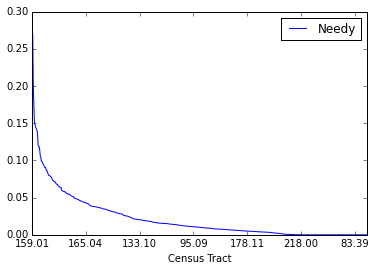

In [19]:
ordered_need = linkage.sort_values(['Needy'], ascending=0)
ordered_need.plot(x=['Census Tract'], y=['Needy'])
plt.show()

The "elbow" appears at approximately 0.5 - 0.6 "neediness." Let's see how many tracts have a neediness above this value.

In [20]:
#how many have neediness about this elbow?
np.shape(ordered_need[ordered_need['Needy'] > 0.055])[1]

8

In [21]:
#write out the neediest for further analysis
ordered_need_top = ordered_need[ordered_need['Needy'] > 0.055]
ordered_need_top.to_csv('agency_tract_filtered.csv', index=False)

# Estimate how many people the top agencies serve
We found that 16 agencies account for 50% of the distributed volume. This section uses the census data and catchment areas to find the approximate number of people these agencies serve.


In [22]:
all_star_agencies = [1189, 1172, 1289, 1064, 1079, 1108, 1065, 1351, 1006, 1146, 1325, 1028, 1381, 1216, 1177, 1178]
select = [i in all_star_agencies for i in linkage["Agency #"].values]
all_star_selector = linkage[select]

In [23]:
print np.shape(all_star_selector)
all_star_selector.head()

(53, 8)


,Census Tract,Agency #,Agency Name,SNAP/Food Stamp Rate,Food Desert Rate,Single Mother Rate,Child Poverty Rate,Needy
5,186.03,1028,Brother Benno Foundation,0.0523996,0.139732,0.150833,23.2,0.00732188
18,202.14,1079,Interfaith Community Services,0.117029,0.0647181,0.143658,44.7,0.00757388
19,206.01,1079,Interfaith Community Services,0.0835821,0.042025,0.251493,28.8,0.00351254
25,201.09,1289,Mission Vida Nueva Food Bank,0.0780757,0.994965,0.044164,20.3,0.0776826
26,57.00,1006,San Diego Rescue Mission,0.0586854,0.779764,0,NaN,0.0457608


53 census tracts are assigned to these 16 agencies, according to our catchment areas. We will approximate the needy population served by each agency by multipling the tracts' population by their food stamp rate; then aggregating this by agency assignment.

In [24]:
top_distributors = sd_data[['TRACT', 'TotalPopulation', 'SNAP_FdStmp']].copy()
top_distributors.columns = ['Census Tract', 'TotalPopulation', 'SNAP/Food Stamp Rate']
top_distributors['NeedyPopulation'] = top_distributors['TotalPopulation'] * top_distributors['SNAP/Food Stamp Rate']



In [25]:
top_distributors_need = all_star_selector.join(top_distributors,how='left',lsuffix='Census Tract')

In [26]:
top_distributors_need_grouped = top_distributors_need.groupby(['Agency #'])
df_to_plot = top_distributors_need_grouped.sum().sort_values(by='NeedyPopulation', ascending=False)
df_to_plot

,Census Tract,TotalPopulation,SNAP/Food Stamp Rate,NeedyPopulation
Agency #,,,,
1064,640.43,38481.0,0.680229,2875.262989
1177,572.04,18170.0,0.505954,2354.270951
1079,2046.50,46198.0,0.460884,2293.067680
1289,1007.34,29916.0,0.448452,2221.579863
1065,108.38,16380.0,0.492430,2058.384995
1189,915.09,23206.0,0.327881,1715.207106
1028,1299.64,32935.0,0.309062,1365.100157
1146,544.20,15381.0,0.184038,731.275970
1216,27.00,13115.0,0.119736,582.622459


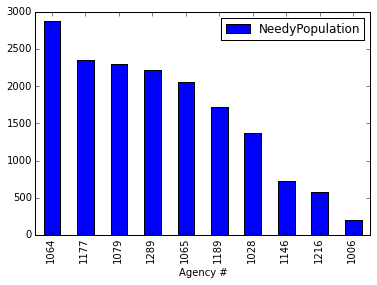

In [27]:
df_to_plot.sort_values(by='NeedyPopulation', ascending=False).plot(y='NeedyPopulation',kind='bar')

Only 10 of the top 16 agencies appear in this aggregration. This is because the missing 6 do not appear in our catchment assignments. This shows a shortcoming of our catchment areas -- top distribution sites do not appear in it.